In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gc
import sys
from statsmodels.formula.api import ols
from IPython.display import clear_output
from numba import njit, jit

### считаем данные по продажам за 18-19 год 

In [21]:
df = pd.read_csv('SALES_2018_2019.csv', sep=',', nrows = 20000000)
df = df[df.stock > 0]
df.rename(columns={'stock': 'Demand', 'store_id': 'Store_ID', 'Code_AP' : 'SKU_ID', 'curr_date': 'Date', 'sales_regular': 'Sales','price_regular':'Regular_Price'}, inplace=True)
df.drop(columns = ['sales_promo','price_promo','flag_promo'])

,SKU_ID,Store_ID,Date,Demand,Sales,Regular_Price
0,114,1078,2018-07-01,2.0,2.0,30.0
1,114,1078,2018-08-05,2.0,0.0,30.0
2,114,1078,2018-08-06,2.0,0.0,30.0
3,114,1078,2018-08-07,2.0,0.0,30.0
4,114,1078,2018-08-08,2.0,0.0,30.0
...,...,...,...,...,...,...
19999995,9790,1127,2018-07-02,5.0,1.0,257.0
19999996,9790,1127,2018-07-03,4.0,2.0,257.0
19999997,9790,1127,2018-07-04,2.0,0.0,257.0
19999998,9790,1127,2018-07-05,2.0,0.0,257.0


In [24]:
df.Date = pd.to_datetime(df.Date)

In [28]:
df.Date[df.Date.dt.year == 2018] 

0          2018-07-01
1          2018-08-05
2          2018-08-06
3          2018-08-07
4          2018-08-08
              ...    
19999995   2018-07-02
19999996   2018-07-03
19999997   2018-07-04
19999998   2018-07-05
19999999   2018-07-06
Name: Date, Length: 9591187, dtype: datetime64[ns]

In [23]:
df = pd.read_csv('DATA_WITH_SALES.csv', sep=';')
df = df[df.Stock > 0]
df.rename(columns={'Stock': 'Demand'}, inplace=True)

df.head(n=5)

,Store_ID,SKU_ID,Date,Sales,Demand,Regular_Price
0,1100,114,01JAN2019,0.0,1.0,51.0
1,1078,114,01JAN2019,0.0,2.0,51.0
2,1191,114,01JAN2019,0.0,2.0,53.0
3,2230,114,01JAN2019,0.0,1.0,40.0
4,1120,114,01JAN2019,0.0,1.0,53.0


In [29]:
df1 = df[df.Date.dt.year == 2019] 
df = df[df.Date.dt.year == 2018] 

#### узнаем по каким парам товар-магазин больше всего информации

In [30]:
popular_pairs = df.groupby(['SKU_ID', 'Store_ID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [31]:
popular_pairs.head(n=10)

,SKU_ID,Store_ID,counts
0,2681,1179,364
1,1063,1199,364
2,678,1178,364
3,7340,2834,364
4,678,1181,364
5,7450,2834,364
6,678,1200,364
7,4405,1172,364
8,1064,1181,364
9,1064,1175,364


In [35]:
pairs_for_experiment = []
num_of_pairs = 10000
for i, r in popular_pairs.iterrows():
    if i == num_of_pairs:
        break
    pairs_for_experiment.append((r['SKU_ID'], r['Store_ID']))

In [36]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [37]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [38]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [39]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [40]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [41]:
def GeneratePEDModels(dataset):
    model_type = 'log-log'
    sku_id, store_id, elas, qty, ttpvalue = [], [], [], [], []
    iter_count = 0

    for good_id, shop_id in pairs_for_experiment:
        data = dataset[(dataset.Store_ID == shop_id) & (dataset.SKU_ID == good_id)]
        model = PEDmodel(data.Regular_Price, data.Demand, model_type)
        
        c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

        sku_id.append(good_id)
        store_id.append(shop_id)
        elas.append(e)
        ttpvalue.append(tp)
        qty.append(data.Demand.sum() / data.shape[0])
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Elasticity': elas,
        'Qty': qty,
        'P_value': ttpvalue
    })

#### посчитаем эластичность и статистики для пар товар-магазин

In [42]:
trained_data = GeneratePEDModels(df)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [2]:
trained_data.to_csv('train_data.csv')

NameError: name 'trained_data' is not defined

In [2]:
trained_data = pd.read_csv('train_data.csv')
tested_data = pd.read_csv('tested_data.csv')

In [3]:
df_train = trained_data[(trained_data.Elasticity > -10) & (trained_data.Elasticity < 0) & (trained_data.P_value < 0.05)]
df_test = tested_data[(tested_data.Elasticity > -10) & (tested_data.Elasticity < 0) & (tested_data.P_value < 0.05)]

In [4]:
df_train.drop(columns=['Unnamed: 0'], inplace=True)
df_test.drop(columns=['Unnamed: 0'], inplace=True)
df_train.head()

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,SKU,Store,Elasticity,Qty,P_value
2,5320,2834,-1.711069,1030.051648,7.047693e-18
3,738,2834,-2.532597,640.582418,9.890574e-14
5,1948,2834,-2.078973,305.859890,1.233518e-64
6,5899,2834,-0.960302,580.002747,2.594262e-36
7,7396,2834,-0.888237,4414.964286,1.285520e-10


#### вытаскиваем фичи с данными о товарах

In [5]:
product_info = pd.read_excel('PRODUCT_INF.xlsx')
product_info.rename(columns={'Code_AP': 'SKU'}, inplace=True)

In [6]:
product_info[product_info.SKU == 97140]

,ProductName,SKU,ClassId,GroupId,SubGroupId,CategoryId,ClusterId,Class,Groups,SubGroups,Category,Cluster
192058,Контролок таб.п.кш.о.20мг №14,97140,2003,2047,2099,2532,994,Лекарственные и профилактические средства,Пищеварительный тракт,Для улучшения пищеварения,Ингибиторы протонной помпы,Пантопразол


In [7]:
product_info = product_info[['SKU', 'ClassId', 'CategoryId', 'ClusterId']]

In [8]:
product_info.head()

,SKU,ClassId,CategoryId,ClusterId
0,9999999,-5,-2,-1
1,122139,-5,-2,-1
2,122140,-5,-2,-1
3,122141,-5,-2,-1
4,122142,-5,-2,-1


In [9]:
df_sku = df_train.join(product_info.set_index('SKU'), on='SKU')
df_sku_test = df_test.join(product_info.set_index('SKU'), on='SKU')

In [10]:
df_sku.isna().sum()

SKU           0
Store         0
Elasticity    0
Qty           0
P_value       0
ClassId       0
CategoryId    0
ClusterId     0
dtype: int64

In [11]:
df_sku.head()

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId
2,5320,2834,-1.711069,1030.051648,7.047693e-18,2003,2491,1055
3,738,2834,-2.532597,640.582418,9.890574e-14,2003,2849,470
5,1948,2834,-2.078973,305.859890,1.233518e-64,2003,2489,466
6,5899,2834,-0.960302,580.002747,2.594262e-36,2003,2495,46
7,7396,2834,-0.888237,4414.964286,1.285520e-10,2003,2496,457


#### вытаскиваем фичи магазинов

In [12]:
store_info = pd.read_excel('LOCATION_INF.xlsx')
store_info.rename(columns={'TradePointId': 'Store'}, inplace=True)

In [13]:
import string
store_info['TradePointName'] = store_info['TradePointName'].str.upper()
store_info['TradePointName'] = store_info['TradePointName'].str.split(' ').str[0]
store_info['TradePointName'] = store_info['TradePointName'].replace(r'[{}]'.format(string.punctuation), '', regex=True)
set(store_info['TradePointName'])

{'ВО', 'ВОЛОГДА', 'ИНТЕРНЕТМАГАЗИН', 'ЛО', 'СПБ', 'ЧЕРЕПОВЕЦ', 'ШУШАРЫ'}

In [14]:
df_sku = df_sku.join(store_info.set_index('Store'), on='Store')
df_sku_test = df_sku_test.join(store_info.set_index('Store'), on='Store')

In [15]:
df_sku

,SKU,Store,Elasticity,Qty,P_value,ClassId,CategoryId,ClusterId,TradePointCode,TradePointName,OpenDate,CloseDate,BrandName,BrandGroupId,Brands_GUID,BE_Id,BE_Name,BE_GUID
2,5320,2834,-1.711069,1030.051648,7.047693e-18,2003,2491,1055,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
3,738,2834,-2.532597,640.582418,9.890574e-14,2003,2849,470,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
5,1948,2834,-2.078973,305.859890,1.233518e-64,2003,2489,466,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
6,5899,2834,-0.960302,580.002747,2.594262e-36,2003,2495,46,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
7,7396,2834,-0.888237,4414.964286,1.285520e-10,2003,2496,457,А02829,ИНТЕРНЕТМАГАЗИН,2019-01-01,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,1946,1139,-1.020101,2.729577,4.219658e-09,2003,2489,466,А01138,СПБ,2017-02-28,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
9991,490,1108,-1.659158,11.201149,2.653524e-10,2003,2489,466,А01107,СПБ,2015-03-16,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
9994,7398,1173,-7.230105,3.211268,9.023607e-35,2003,2692,455,А01172,СПБ,2017-10-11,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8
9995,7396,1089,-1.055770,26.873156,8.415907e-07,2003,2496,457,А01088,СПБ,2009-02-11,2100-01-01,Озерки,3.0,E378FD87-0BB5-E984-11E8-54EE74216F5D,25.0,БЕ Озерки СЗ,5000DB80-9356-86BC-11E8-82B3A92564D8


In [16]:
df_sku.isna().sum()

SKU                0
Store              0
Elasticity         0
Qty                0
P_value            0
ClassId            0
CategoryId         0
ClusterId          0
TradePointCode    32
TradePointName    32
OpenDate          32
CloseDate         32
BrandName         32
BrandGroupId      32
Brands_GUID       32
BE_Id             32
BE_Name           32
BE_GUID           32
dtype: int64

In [17]:
df_sku = df_sku.rename(columns = {'TradePointName': 'Region'})
df_sku_test = df_sku_test.rename(columns = {'TradePointName': 'Region'})

In [18]:
store_info.BrandGroupId.value_counts()

3    184
Name: BrandGroupId, dtype: int64

In [19]:
store_info.BE_Id.value_counts()

25    184
Name: BE_Id, dtype: int64

In [20]:
store_info.Brands_GUID.value_counts()

E378FD87-0BB5-E984-11E8-54EE74216F5D    184
Name: Brands_GUID, dtype: int64

In [21]:
import time
df_sku['OpenDate'] = pd.to_datetime(df_sku.OpenDate)
#cur_date = time.mktime(time.strptime('01/01/2019', "%d/%m/%Y"))
df_sku['OpenDate'] = df_sku['OpenDate'].rsub(pd.Timestamp('today')).dt.days
df_sku.rename(columns={'OpenDate' : 'DaysOpen'}, inplace = True)

df_sku_test['OpenDate'] = pd.to_datetime(df_sku_test.OpenDate)
df_sku_test['OpenDate'] = df_sku_test['OpenDate'].rsub(pd.Timestamp('today')).dt.days
df_sku_test.rename(columns={'OpenDate' : 'DaysOpen'}, inplace = True)


In [22]:
df_sku.DaysOpen = df_sku['DaysOpen'].fillna(0)
df_sku_test.DaysOpen = df_sku_test['DaysOpen'].fillna(0)

### какие признаки у нас будут для обучения

In [23]:
X = df_sku[['SKU', 'Store', 'CategoryId', 'ClusterId', 'Region', 'DaysOpen']]
one_hot = pd.get_dummies(X['Region'])
# Drop column B as it is now encoded
X = X.drop('Region',axis = 1)
# Join the encoded df
X = X.join(one_hot)
print(X)
X = X.to_numpy()  
y = df_sku['Elasticity'].to_numpy()

       SKU  Store  CategoryId  ClusterId  DaysOpen  ВО  ВОЛОГДА  \
2     5320   2834        2491       1055     880.0   0        0   
3      738   2834        2849        470     880.0   0        0   
5     1948   2834        2489        466     880.0   0        0   
6     5899   2834        2495         46     880.0   0        0   
7     7396   2834        2496        457     880.0   0        0   
...    ...    ...         ...        ...       ...  ..      ...   
9990  1946   1139        2489        466    1552.0   0        0   
9991   490   1108        2489        466    2267.0   0        0   
9994  7398   1173        2692        455    1327.0   0        0   
9995  7396   1089        2496        457    4491.0   0        0   
9997  1554   1091        2561         28    4625.0   0        0   

      ИНТЕРНЕТМАГАЗИН  ЛО  СПБ  ЧЕРЕПОВЕЦ  
2                   1   0    0          0  
3                   1   0    0          0  
5                   1   0    0          0  
6                  

In [24]:
X_test = df_sku_test[['SKU', 'Store', 'CategoryId', 'ClusterId', 'Region', 'DaysOpen']]
one_hot = pd.get_dummies(X_test['Region'])
# Drop column B as it is now encoded
X_test = X_test.drop('Region',axis = 1)
# Join the encoded df
X_test = X_test.join(one_hot)
print(X_test)
X_test = X_test.to_numpy()  
y_test = df_sku_test['Elasticity'].to_numpy()

       SKU  Store  CategoryId  ClusterId  DaysOpen  ВО  ВОЛОГДА  \
0      691   2834        2489        467     880.0   0        0   
1     1483   2834        2855         43     880.0   0        0   
3      738   2834        2849        470     880.0   0        0   
4     4240   1191        2692        455    6724.0   0        0   
8     8215   2834        2547          5     880.0   0        0   
...    ...    ...         ...        ...       ...  ..      ...   
9990  1946   1139        2489        466    1552.0   0        0   
9991   490   1108        2489        466    2267.0   0        0   
9992   546   1139        2489        464    1552.0   0        0   
9993   546   1138        2489        464    1564.0   0        0   
9999  3043   1100        2928         26    4099.0   0        0   

      ИНТЕРНЕТМАГАЗИН  ЛО  СПБ  ЧЕРЕПОВЕЦ  
0                   1   0    0          0  
1                   1   0    0          0  
3                   1   0    0          0  
4                  

In [25]:
len(df_sku['ClusterId'].unique())

74

#### добавим признаки медианной эластичности по категории товара и город-магазина или интернтет магазина

In [26]:
Z = df_sku[['SKU', 'Store', 'CategoryId', 'ClusterId', 'Region', 'DaysOpen','Elasticity']]
Z['MedianElastCategory'] = 0
Z['MedianElastStores'] = 0
Z_test = df_sku_test[['SKU', 'Store', 'CategoryId', 'ClusterId', 'Region', 'DaysOpen','Elasticity']]
Z_test['MedianElastCategory'] = 0
Z_test['MedianElastStores'] = 0
Z

<ipython-input-26-2b8294801a0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['MedianElastCategory'] = 0
<ipython-input-26-2b8294801a0f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z['MedianElastStores'] = 0
<ipython-input-26-2b8294801a0f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,SKU,Store,CategoryId,ClusterId,Region,DaysOpen,Elasticity,MedianElastCategory,MedianElastStores
2,5320,2834,2491,1055,ИНТЕРНЕТМАГАЗИН,880.0,-1.711069,0,0
3,738,2834,2849,470,ИНТЕРНЕТМАГАЗИН,880.0,-2.532597,0,0
5,1948,2834,2489,466,ИНТЕРНЕТМАГАЗИН,880.0,-2.078973,0,0
6,5899,2834,2495,46,ИНТЕРНЕТМАГАЗИН,880.0,-0.960302,0,0
7,7396,2834,2496,457,ИНТЕРНЕТМАГАЗИН,880.0,-0.888237,0,0
...,...,...,...,...,...,...,...,...,...
9990,1946,1139,2489,466,СПБ,1552.0,-1.020101,0,0
9991,490,1108,2489,466,СПБ,2267.0,-1.659158,0,0
9994,7398,1173,2692,455,СПБ,1327.0,-7.230105,0,0
9995,7396,1089,2496,457,СПБ,4491.0,-1.055770,0,0


In [27]:
mean_val_reg = []
mean_val_categ = []
for i, r in Z.iterrows():
    x = r['Region'] 
    y = r['CategoryId'] 
    Y = Z.drop([i])
    mean_val_reg.append(Y[Y.Region == x].Elasticity.mean())
    mean_val_categ.append(Y[Y.CategoryId == y].Elasticity.mean())
Z.MedianElastStores = mean_val_reg
Z.MedianElastCategory = mean_val_categ

mean_val_reg = []
mean_val_categ = []
for i, r in Z_test.iterrows():
    x = r['Region'] 
    y = r['CategoryId'] 
    Y = Z_test.drop([i])
    mean_val_reg.append(Y[Y.Region == x].Elasticity.mean())
    mean_val_categ.append(Y[Y.CategoryId == y].Elasticity.mean())
Z_test.MedianElastStores = mean_val_reg
Z_test.MedianElastCategory = mean_val_categ
Z

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,SKU,Store,CategoryId,ClusterId,Region,DaysOpen,Elasticity,MedianElastCategory,MedianElastStores
2,5320,2834,2491,1055,ИНТЕРНЕТМАГАЗИН,880.0,-1.711069,-1.725599,-2.521124
3,738,2834,2849,470,ИНТЕРНЕТМАГАЗИН,880.0,-2.532597,-2.306946,-2.513789
5,1948,2834,2489,466,ИНТЕРНЕТМАГАЗИН,880.0,-2.078973,-3.315881,-2.517839
6,5899,2834,2495,46,ИНТЕРНЕТМАГАЗИН,880.0,-0.960302,-4.259721,-2.527827
7,7396,2834,2496,457,ИНТЕРНЕТМАГАЗИН,880.0,-0.888237,-3.381363,-2.528470
...,...,...,...,...,...,...,...,...,...
9990,1946,1139,2489,466,СПБ,1552.0,-1.020101,-3.316816,-3.086097
9991,490,1108,2489,466,СПБ,2267.0,-1.659158,-3.316252,-3.085956
9994,7398,1173,2692,455,СПБ,1327.0,-7.230105,-2.467494,-3.084730
9995,7396,1089,2496,457,СПБ,4491.0,-1.055770,-3.380149,-3.086089


In [28]:
one_hot = pd.get_dummies(Z['Region'])
# Drop column B as it is now encoded
Z = Z.drop('Region',axis = 1)
# Join the encoded df
Z = Z.join(one_hot)

one_hot = pd.get_dummies(Z_test['Region'])
# Drop column B as it is now encoded
Z_test = Z_test.drop('Region',axis = 1)
# Join the encoded df
Z_test = Z_test.join(one_hot)

In [29]:
Z.MedianElastCategory = Z.MedianElastCategory.fillna(Z.MedianElastCategory.median())
Z.MedianElastStores = Z.MedianElastStores.fillna(Z.MedianElastStores.median())

Z_test.MedianElastCategory = Z_test.MedianElastCategory.fillna(Z_test.MedianElastCategory.median())
Z_test.MedianElastStores = Z_test.MedianElastStores.fillna(Z_test.MedianElastStores.median())

In [30]:
Z

,SKU,Store,CategoryId,ClusterId,DaysOpen,Elasticity,MedianElastCategory,MedianElastStores,ВО,ВОЛОГДА,ИНТЕРНЕТМАГАЗИН,ЛО,СПБ,ЧЕРЕПОВЕЦ
2,5320,2834,2491,1055,880.0,-1.711069,-1.725599,-2.521124,0,0,1,0,0,0
3,738,2834,2849,470,880.0,-2.532597,-2.306946,-2.513789,0,0,1,0,0,0
5,1948,2834,2489,466,880.0,-2.078973,-3.315881,-2.517839,0,0,1,0,0,0
6,5899,2834,2495,46,880.0,-0.960302,-4.259721,-2.527827,0,0,1,0,0,0
7,7396,2834,2496,457,880.0,-0.888237,-3.381363,-2.528470,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,1946,1139,2489,466,1552.0,-1.020101,-3.316816,-3.086097,0,0,0,0,1,0
9991,490,1108,2489,466,2267.0,-1.659158,-3.316252,-3.085956,0,0,0,0,1,0
9994,7398,1173,2692,455,1327.0,-7.230105,-2.467494,-3.084730,0,0,0,0,1,0
9995,7396,1089,2496,457,4491.0,-1.055770,-3.380149,-3.086089,0,0,0,0,1,0


In [31]:
Z_test

,SKU,Store,CategoryId,ClusterId,DaysOpen,Elasticity,MedianElastCategory,MedianElastStores,ВО,ВОЛОГДА,ИНТЕРНЕТМАГАЗИН,ЛО,СПБ,ЧЕРЕПОВЕЦ
0,691,2834,2489,467,880.0,-6.446472,-3.696257,-2.569006,0,0,1,0,0,0
1,1483,2834,2855,43,880.0,-0.457565,-3.785884,-2.619759,0,0,1,0,0,0
3,738,2834,2849,470,880.0,-2.307756,-4.084705,-2.604079,0,0,1,0,0,0
4,4240,1191,2692,455,6724.0,-5.119616,-4.299051,-3.533323,0,0,0,0,1,0
8,8215,2834,2547,5,880.0,-0.066233,-2.737076,-2.623075,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,1946,1139,2489,466,1552.0,-1.413106,-3.701346,-3.534142,0,0,0,0,1,0
9991,490,1108,2489,466,2267.0,-1.305517,-3.701455,-3.534166,0,0,0,0,1,0
9992,546,1139,2489,464,1552.0,-6.173850,-3.696532,-3.533089,0,0,0,0,1,0
9993,546,1138,2489,464,1564.0,-1.965747,-3.700787,-3.534020,0,0,0,0,1,0


In [32]:
y_train = Z['Elasticity'].to_numpy()
X_train = Z.drop('Elasticity',axis = 1)
X_train = X_train.to_numpy()  

y_test = Z_test['Elasticity'].to_numpy()
X_test = Z_test.drop('Elasticity',axis = 1)
X_test = X_test.to_numpy()  

In [33]:
'''from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)'''

'from sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)'

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor()
reg = rf.fit(X_train, y_train)

In [35]:
mean_squared_error(y_test, reg.predict(X_test))

15.049653547897682

Text(0, 0.5, 'Predictions')

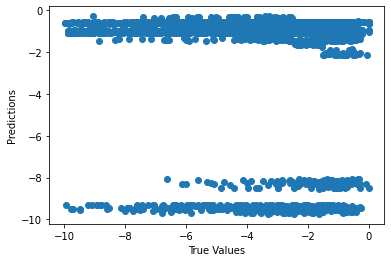

In [36]:
plt.scatter(y_test, reg.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

# RandomForest

## подбор гипер параметров

Fitting 6 folds for each of 144 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.3min finished


{'bootstrap': True, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 150}
7.858468932436326


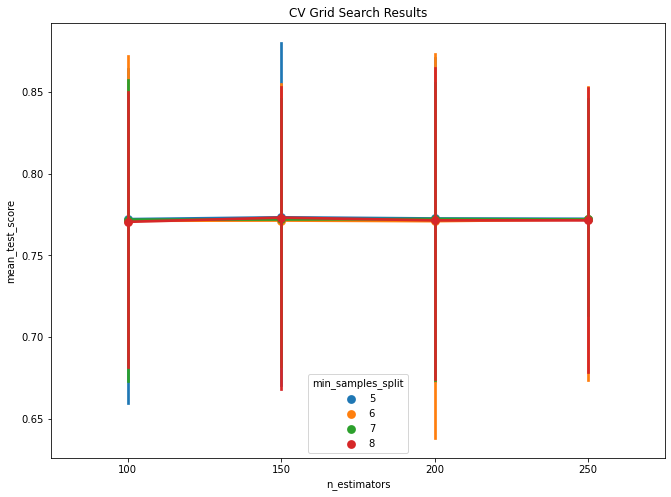

In [37]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 3, 4], 
    'min_samples_leaf': [2,3,4],
    'min_samples_split': [5, 6, 7, 8],
    'n_estimators': [100,150,200,250]
}
# Create a based model

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#fig, axs = plt.subplots(figsize=(16, 5), ncols=4)


print(mean_squared_error(y_test, grid_search.predict(X_test)))
fig = plot_cv_results(grid_search.cv_results_, 'n_estimators', 'min_samples_split')

Text(0, 0.5, 'Predictions')

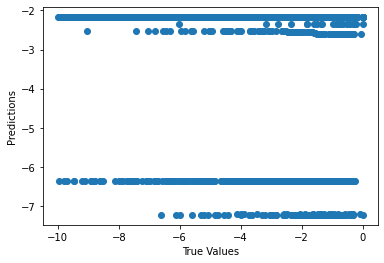

In [38]:
plt.scatter(y_test, grid_search.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

# Catboost

## Подбор гиперпараметров

Fitting 6 folds for each of 18 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  2.2min finished


{'bagging_temperature': 0, 'bootstrap_type': 'Bayesian', 'learning_rate': 0.3}
9.612056143089454


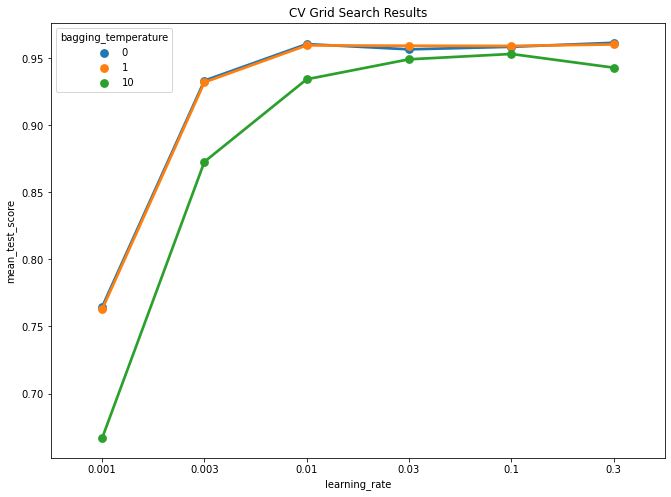

In [42]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
# Create a based model
cb = CatBoostRegressor(verbose=False)
# Instantiate the grid search model
param_grid = {
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'bootstrap_type':['Bayesian'],
    'bagging_temperature': [0, 1, 10]
}
grid_search = GridSearchCV(estimator = cb, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#fig, axs = plt.subplots(figsize=(16, 5), ncols=4)

print(mean_squared_error(y_test, grid_search.predict(X_test)))


fig = plot_cv_results(grid_search.cv_results_, 'learning_rate', 'bagging_temperature')

Text(0, 0.5, 'Predictions')

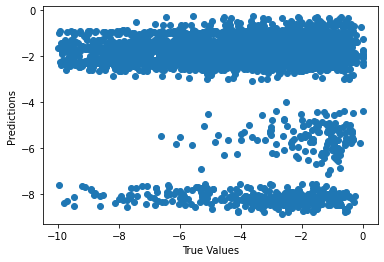

In [43]:
plt.scatter(y_test, grid_search.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")

# XGBoost

## Подбор гиперпараметров

Fitting 6 folds for each of 54 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   31.1s finished


{'gamma': 0.003, 'max_depth': 4, 'min_child_weight': 3}
13.474755347229932


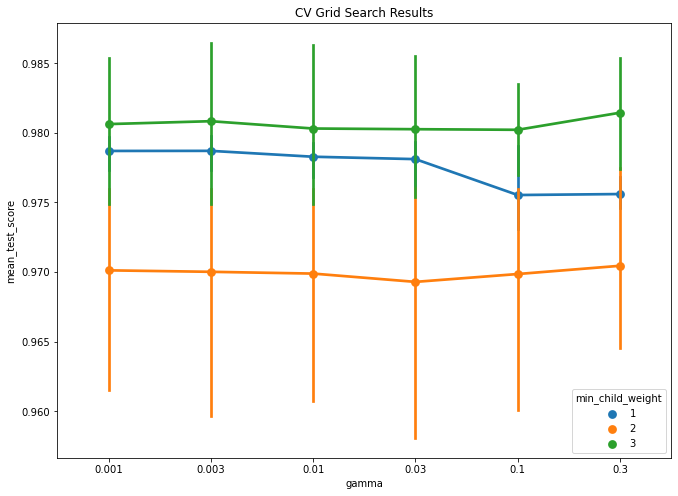

In [44]:
from xgboost import XGBRegressor


xgb = XGBRegressor(nthread=-1)

param_grid = {
    'max_depth': [2, 3, 4],
    'min_child_weight':[1,2,3],
    'gamma':[0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
}


grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 6, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#fig, axs = plt.subplots(figsize=(16, 5), ncols=4)

print(mean_squared_error(y_test, grid_search.predict(X_test)))


fig = plot_cv_results(grid_search.cv_results_, 'gamma', 'min_child_weight')


Text(0, 0.5, 'Predictions')

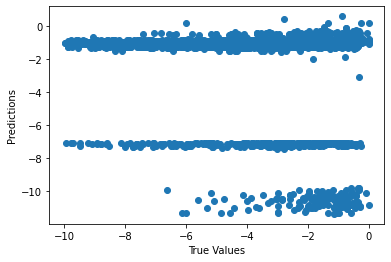

In [45]:
plt.scatter(y_test, grid_search.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")